# Pre-Class Assignment: Polynomial Regression
# Day 14 
# CMSE 202
<img src="https://i.pinimg.com/originals/52/2c/20/522c209c019fe9592857bcb569184478.jpg">

### <p style="text-align: right;"> &#9989; Juan José Lozano González</p>

## Goals for Pre-Class Assignment

After this pre-class assignment, you will be able to:
1. Generate data for a polynomial regression
2. Construct a set of polynomial regression models usings `statsmodels` 
3. Evaluate the quality of fit for a set of models using adjusted $R^2$ and determine the best fit
4. Explain why that model is the best fit for this data

## Our Imports

**Make sure to execute this cell!**

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

sns.set_context("notebook")
import statsmodels.api as sm
from IPython.display import HTML

---
## 1. Polynomial Regression

Previously we focused on fitting a line to data, but as we've seen, it's possible that a straight line is not going to be good enough to model the data we are working with. We can augment our $ Ax + B$ with extra features. By adding features we are still doing linear regression, but where the features themselves can consist of, well anything.

However, to limit our focus, for this pre-class we will use polynomials. We can add values like $x^2$ or $x^5$ to the potential set of features that can be used to better map against our data. 

&#9989; **Do This**: The question we should ask ourselves is, how many such features should we add? What are the advantages and disadvantages of adding more and more features? Think about it and answer in the cell below.

<font size=+3>&#9998;</font> Adding too many features adds to the computing time and to the complexity of the problem which may lead to overfitting, while not adding enough features leads to a model that doesn't adequately convey the values expressed.

### 1.1 Let's make some Data

When we are first starting out with a new tool, it can be useful to generate our own data. Data we generate gives us the advantage of **knowing** what the answer should be. 

&#9989; **Do This**: Generate some data by doing the following:
* build a numpy array `x_ary` of values from -4 to 4 in increments of 0.2
* generate a corresponding `y_ary`, using the values from `x_ary`, based on the formula $x^4 + 2x^3 -15x^2 -12x + 36$
* create `y_noisy`, by adding random (uniform) noise to `y_ary` in the range of -15 to 15. Later on we might make the range bigger (say -25 to 25) or smaller (say -5 to 5) for comparison.

In [25]:
def noise_creator(array, range):
    array = array + ((np.random.random(len(array))*2)-1) * range
    return array

In [26]:
x_ary = np.arange(-4, 4.2, 0.2)
y_ary = x_ary**4 + 2*x_ary**3 - 15*x_ary**2 - 12*x_ary + 36
y_noisy = noise_creator(y_ary, 15)

### 1.2 Plot the data

As always, it's been to look at our data before we try to model it.

&#9989; **Do This**: Plot `x_ary` vs both `y_ary` and `y_noisy`. Do it overlapping with colors, or side by side, whatever you think would look good. _Make sure to label your axes!_

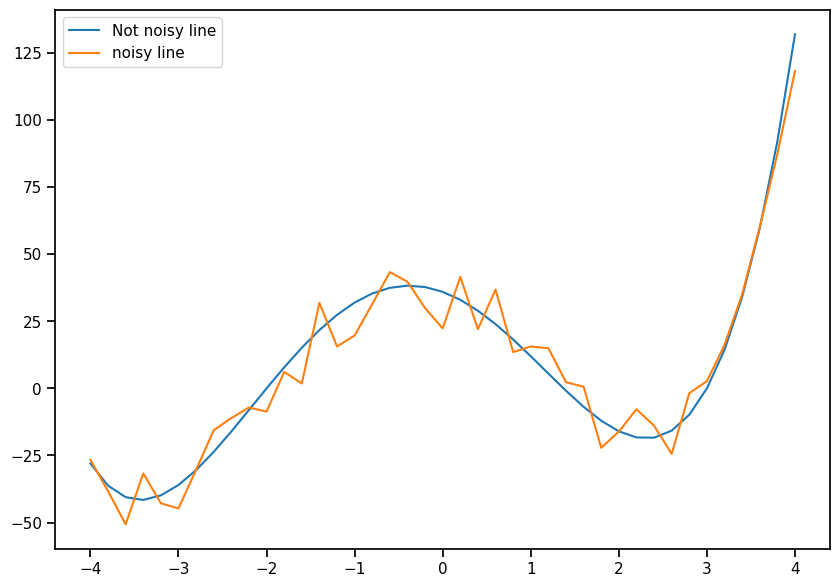

In [27]:
# put your code here
fig = plt.figure(figsize = (10,7))
plt.plot(x_ary, y_ary, label = "Not noisy line")
plt.plot(x_ary, y_noisy, label = "noisy line")
plt.legend()

---
## 2 Making the Polynomial Features

Ultimately it would be nice to do our work using a `pandas` DataFrame so that we have the opportunity to label our columns. There's the added benefit that `statsmodels` works well with `pandas` DataFrames. 

&#9989; **Do This**: Make a DataFrame consisting of the following columns: a constant value for the intercept, the values in `x_ary`, and additional powers of `x_ary` up to 10.

You can do this one of two ways:
1. make the DataFrame out of `x_ary` and add features to the DataFrame
2. add columns to the `x_ary` array and then finish off by adding to a DataFrame

In the end, you have a DataFrame no matter the approach.

To state the goal for this task again, the columns of the DataFrame should be:
* Label the first column "const" and just place the value 1 in it
* make the `x_ary` data column 1, labeled "data"
* the next 9 columns should be based on `x_ary` and have as values: $x^2$, $x^3$, $x^4 \ldots$ $x^{10}$. Give them good (but short) label names

Print the head of your DataFrame when you're done to make sure it looks right. It should end up looking something like this:

<img src="https://i.ibb.co/FX5fs7f/Screen-Shot-2021-03-05-at-3-43-11-PM.png" alt="Screen-Shot-2021-03-05-at-3-43-11-PM" border="0" width=800px>

In [29]:
df = {"const" : np.ones_like(x_ary),
      "data" : x_ary,
      "x2" : x_ary**2,
      "x3" : x_ary**3,
      "x4" : x_ary**4,
      "x5" : x_ary**5,
      "x6" : x_ary**6,
      "x7" : x_ary**7,
      "x8" : x_ary**8,
      "x9" : x_ary**9,
      "x10" : x_ary**10}

df = pd.DataFrame(df)

In [30]:
df.head()

,const,data,x2,x3,x4,x5,x6,x7,x8,x9,x10
0,1.0,-4.0,16.00,-64.000,256.0000,-1024.00000,4096.000000,-16384.000000,65536.000000,-262144.000000,1.048576e+06
1,1.0,-3.8,14.44,-54.872,208.5136,-792.35168,3010.936384,-11441.558259,43477.921385,-165216.101263,6.278212e+05
2,1.0,-3.6,12.96,-46.656,167.9616,-604.66176,2176.782336,-7836.416410,28211.099075,-101559.956668,3.656158e+05
3,1.0,-3.4,11.56,-39.304,133.6336,-454.35424,1544.804416,-5252.335014,17857.939049,-60716.992766,2.064378e+05
4,1.0,-3.2,10.24,-32.768,104.8576,-335.54432,1073.741824,-3435.973837,10995.116278,-35184.372089,1.125900e+05


### 2.1 Fitting using the Polynomials

We'll talk about measures of "goodness" of fit during the class, but one good measure for a multi-feature fit is the **Adjusted R-squared** value. In general, the **R-squared** describes the variance in the model that it can account for. If the R-squared is 1.0, then all the variance is accounted for an you have a perfect fit. If the value is 0 and you have no fit. However, for multiple features R-squared tends to over-estimate. The Adjusted R-squared tries to deal with this and provide a value that is better suited to multiple features.

We'll leave it to you how you want to do this, but what we'd like you to try is to fit different combinations of features against `y_noisy` and report the Adjusted R-squared value. For example, what is the Adjusted R-squared for:

1. just the const column
2. the const and data columns (which should be a line)
3. the const, data and $x^2$ columns
4. the const, data, $x^2$ and $x^3$ columns
5. $\ldots$

So on and so forth. You can do them individually or on a loop and collect the results. 

The object that is returned by the `.fit()` method is an instance of a `statsmodels` "`statsmodels.regression.linear_model.RegressionResults`". Run the `type` command on it and see. If you look on the <a href="https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.RegressionResults.html#statsmodels.regression.linear_model.RegressionResults"> statsmodels doc page </a> under "Properties" (scroll down and look for that word as a title), you will find  all values you can gather from the variable returned by `.fit()`. For this assignment the most important one of those is `.rsquared_adj`. 

&#9989; **Do This**: Explore a variety of models that fit to the noisy data using increasingly more features. Look at that value for the combination of features you selected and say which one is the "best". For this assignment, we would consider the "best" would be the highest value of `.rsquared_adj`.

**Note**: you do not have to try an exhaustive set of models (though you could set this up with a loop), just explore a variety of combinations and reflect on the results.

In [54]:
# Define the features
features = ['const', 'data', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10']

# Loop over different combinations of features
for i in range(1, len(features) + 1):
    selected_features = features[:i]  # Select the first i features
    X = df[selected_features].values
    model = sm.OLS(y_noisy, X)
    result = model.fit()
    print(f"Combination of features: {selected_features}")
    print(f"Adjusted R-squared: {result.rsquared_adj}\n")

Combination of features: ['const']
Adjusted R-squared: 0.0

Combination of features: ['const', 'data']
Adjusted R-squared: 0.31486234900972965

Combination of features: ['const', 'data', 'x2']
Adjusted R-squared: 0.30863419433205663

Combination of features: ['const', 'data', 'x2', 'x3']
Adjusted R-squared: 0.6022577761839949

Combination of features: ['const', 'data', 'x2', 'x3', 'x4']
Adjusted R-squared: 0.9535315252026331

Combination of features: ['const', 'data', 'x2', 'x3', 'x4', 'x5']
Adjusted R-squared: 0.952238934512416

Combination of features: ['const', 'data', 'x2', 'x3', 'x4', 'x5', 'x6']
Adjusted R-squared: 0.9510482565402719

Combination of features: ['const', 'data', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7']
Adjusted R-squared: 0.9530467184901861

Combination of features: ['const', 'data', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8']
Adjusted R-squared: 0.9516393820364862

Combination of features: ['const', 'data', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9']
Adjusted R-squar

&#9989; **Questions**: Which combination of features best "fit" your data? What was the Adjusted R-squared? Why might that combination produce the best fit?

<font size=+3>&#9998;</font> everything after x**4 seems to work well.

---
## 3 Plot your data and your model

&#9989; **Do this**:  Plot `x_ary` vs `y_noisy` and `x_ary` vs the best fitted values based on the adjusted R-squared value. Do it in the same graph. Again, the Property `.fittedvalues` gives out a panda Series with the fitted values (the y values for your best fit model). Also print out the summary for the variable returned by `.fit()`

Your plot might end up looking something like this:

<img src="https://i.ibb.co/z6LrB3N/best-fit.png" alt="best-fit" border="0" width=300>

In [57]:
selected_features = features[:5]  # Select the first i features
X = df[selected_features].values
model = sm.OLS(y_noisy, X)
result = model.fit()

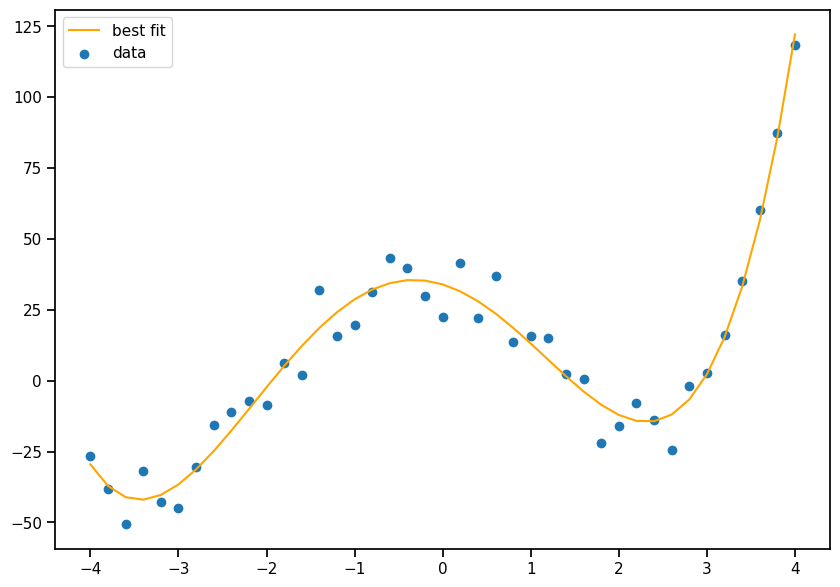

In [60]:
# put your code here
fig = plt.figure(figsize = (10,7))
plt.plot(x_ary, result.predict(), label = "best fit", color = "orange")
plt.scatter(x_ary, y_noisy, label = "data")
plt.legend()


### 3.1 Are we justified in using this model?

As we did previously, we can check how well we are justified in using this model, by looking at the residual plot. 

&#9989; **Do this**: Again, using `plot_regress_exog`, plot the residuals as a function of the independent variable (`data` or `x`, whatever you called it).

In [64]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     206.2
Date:                Tue, 05 Mar 2024   Prob (F-statistic):           2.80e-24
Time:                        23:05:48   Log-Likelihood:                -138.23
No. Observations:                  41   AIC:                             286.5
Df Residuals:                      36   BIC:                             295.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         33.9803      2.205     15.411      0.0

c:\Users\JUAN JOSE\anaconda3\Lib\site-packages\statsmodels\graphics\regressionplots.py:430: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fig = abline_plot(0, fitted_line.params[0], color='k', ax=ax)


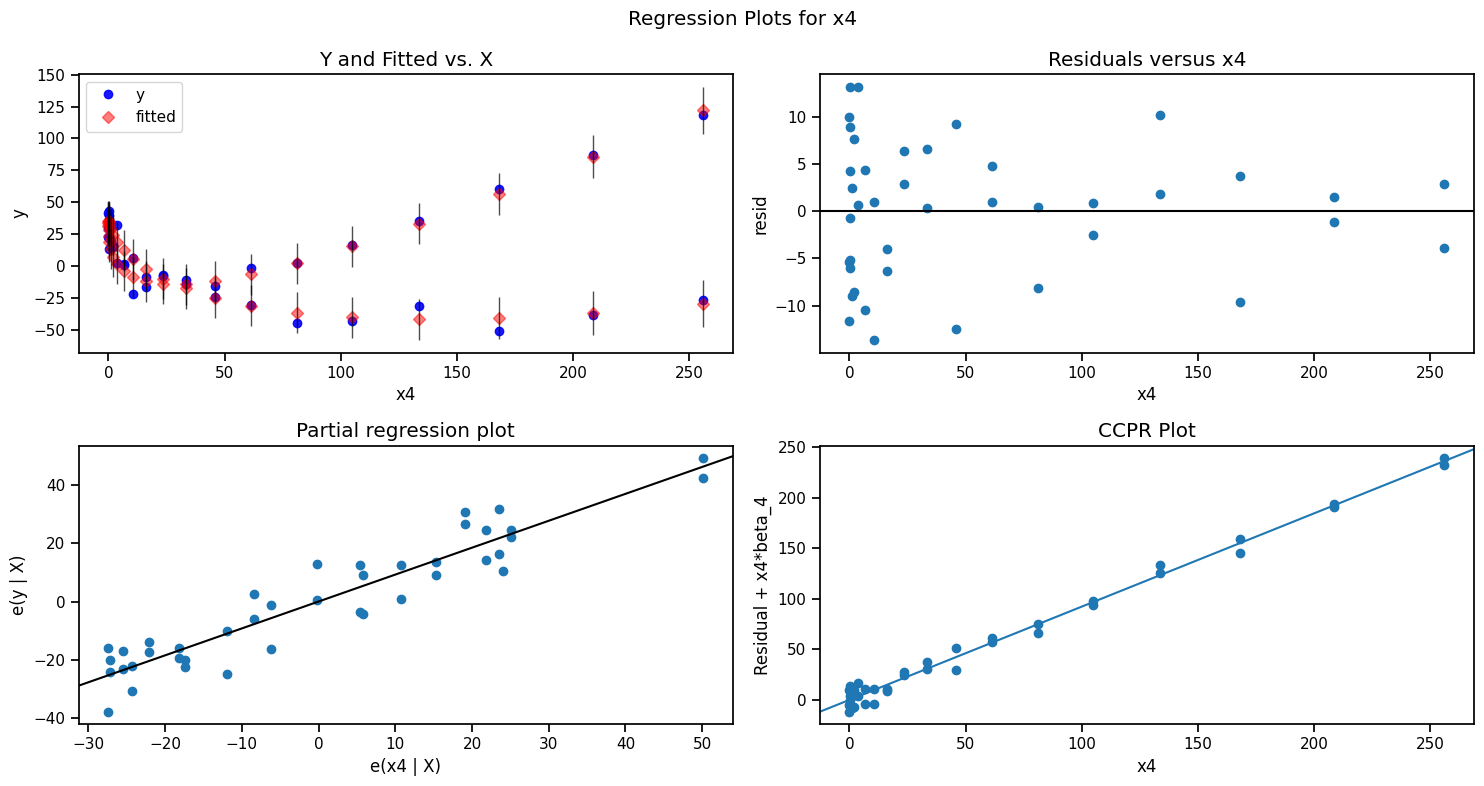

In [65]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(result, "x4", fig=fig)


&#9989; **Question**: Do we appear justified in using this model? Why or why not? 

<font size=+3>&#9998;</font> I would say it is quite good as there is a good adjusted r squared value, and a small value of SME.

The graphs are also about what we would expect.

---
## Follow-up Questions

Copy and paste the following questions into the appropriate box in the assignment survey include below and answer them there. (Note: You'll have to fill out the assignment number and go to the "NEXT" section of the survey to paste in these questions.)

1. Which combination of features best "fit" your data? What was the Adjusted R-squared? Why might that combination produce the best fit? (you should be able to copy your answer to this question from above)

2. Based on your plot of the residuals, do we appear justified in using this model? Why or why not? (you should be able to copy your answer to this question from above)

----

# Assignment wrap-up

Hopefully you were able to get through all of that. We'll be trouble-shooting any issues you had

**You must completely fill this out in order to receive credit for the assignment!**

In [66]:
HTML(
"""
<iframe 
	src="https://cmse.msu.edu/cmse202-pc-survey" 
	width="800px" 
	height="600px" 
	frameborder="0" 
	marginheight="0" 
	marginwidth="0">
	Loading...
</iframe>
"""
)

---------
### Congratulations, you're done with your pre-class assignment!

Now, you just need to submit this assignment by uploading it to the course <a href="https://d2l.msu.edu/">Desire2Learn</a> web page for the appropriate pre-class submission folder (Don't forget to add your name in the first cell).

&#169; Copyright 2023,  Department of Computational Mathematics, Science and Engineering at Michigan State University